# Lumped Elements Circuits

In this notebook, we construct various network from basic lumped elements (resistor, capacitor, inductor), with the 'classic' and the `Circuit` approach. Generally the `Circuit` approach is more verbose than the 'classic' way for building a circuit. However, as the circuit complexity increases, in particular when components are connected in parallel, the `Circuit` approach is interesting as it increases the readability of the code. Moreover, `Circuit` object can be plotted using its `plot_graph()` method, which is usefull to rapidly control if the circuit is built as expected.  

In [18]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [19]:
import skrf as rf
rf.stylely()

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\style\core.py:112: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  _apply_style(rc)


# LC Series Circuit

In this section we reproduce a simple equivalent model of a capacitor $C$, as illustrated by the figure below:
<img src="designer_capacitor_simple.png" style="height:300px">


In [20]:
# reference LC circuit made in Designer
LC_designer = rf.Network('designer_capacitor_30_80MHz_simple.s2p')

In [21]:
# scikit-rf: manually connecting networks
line = rf.media.DefinedGammaZ0(frequency=LC_designer.frequency, z0=50)
LC_manual = line.inductor(24e-9) ** line.capacitor(70e-12)

In [22]:
# scikit-rf: using Circuit builder 
port1 = rf.Circuit.Port(frequency=LC_designer.frequency, name='port1', z0=50)
port2 = rf.Circuit.Port(frequency=LC_designer.frequency, name='port2', z0=50)
line = rf.media.DefinedGammaZ0(frequency=LC_designer.frequency, z0=50)
cap = line.capacitor(70e-12, name='cap')
ind = line.inductor(24e-9, name='ind')

connections = [
    [(port1, 0), (cap, 0)],
    [(cap, 1), (ind, 0)],
    [(ind, 1), (port2, 0)]
]
circuit = rf.Circuit(connections)
LC_from_circuit = circuit.network

In [23]:
# testing the equivalence of the results
print(np.allclose(LC_designer.s, LC_manual.s))
print(np.allclose(LC_designer.s, LC_from_circuit.s))

True
True


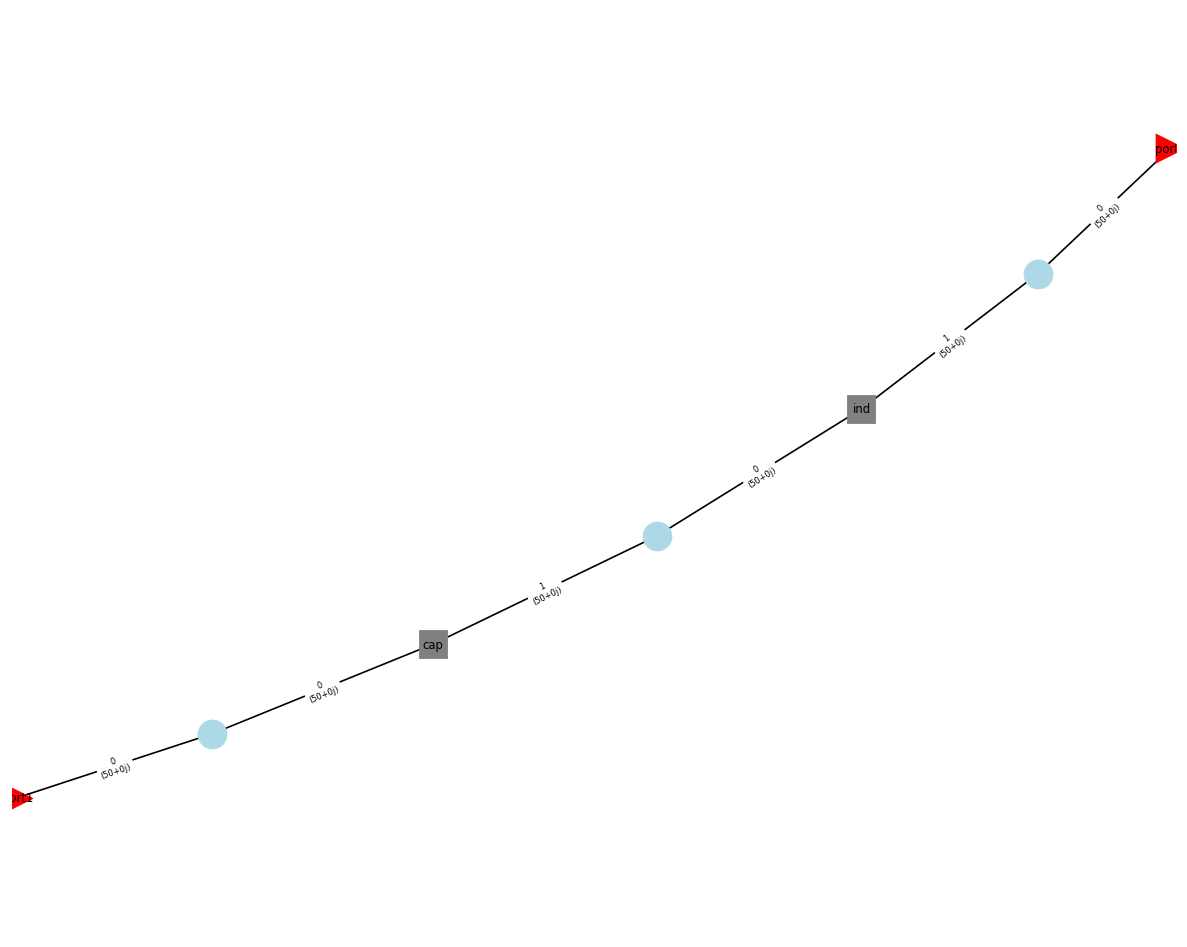

In [24]:
circuit.plot_graph(network_labels=True, edge_labels=True, port_labels=True)

# A More Advanced Equivalent Model

In this section we reproduce an equivalent model of a capacitor $C$, as illustrated by the figure below:
<img src="designer_capacitor_adv.png" style="height:300px">


In [25]:
# Reference results from ANSYS Designer
LCC_designer = rf.Network('designer_capacitor_30_80MHz_adv.s2p')

In [38]:
# scikit-rf: usual way, but this time this is more tedious to deal with connection and port number
freq = LCC_designer.frequency
line = rf.media.DefinedGammaZ0(frequency=freq, z0=50)
elements1 = line.resistor(1e-2) ** line.inductor(24e-9) ** line.capacitor(70e-12)
elements2 = line.resistor(20e6)
T_in = line.tee()
T_out = line.tee()
ntw = rf.connect(T_in, 0, elements1, 0)
ntw = rf.connect(ntw, 2, elements2, 0)
ntw = rf.connect(ntw, 1, T_out, 1)
ntw = rf.innerconnect(ntw, 1, 2)
LCC_manual = ntw ** line.shunt_capacitor(50e-12) 

In [39]:
# scikit-rf: using Circuit builder 
freq = LCC_designer.frequency
port1 = rf.Circuit.Port(frequency=freq, name='port1', z0=50)
port2 = rf.Circuit.Port(frequency=freq, name='port2', z0=50)
line = rf.media.DefinedGammaZ0(frequency=freq, z0=50)
cap = line.capacitor(70e-12, name='cap')
ind = line.inductor(24e-9, name='ind')
res_series = line.resistor(1e-2, name='res_series')
res_parallel = line.resistor(20e6, name='res_parallel')
cap_shunt = line.capacitor(50e-12, name='cap_shunt')
ground = rf.Circuit.Ground(frequency=freq, name='ground', z0=50)

connections = [
    [(port1, 0), (res_series, 0), (res_parallel, 0)],
    [(res_series, 1), (cap, 0)],
    [(cap, 1), (ind, 0)],
    [(ind, 1), (cap_shunt, 0), (res_parallel, 1), (port2, 0)],
    [(cap_shunt, 1), (ground, 0)],
]
circuit = rf.Circuit(connections)
LCC_from_circuit = circuit.network

In [40]:
# testing the equivalence of the results
print(np.allclose(LCC_designer.s, LCC_manual.s))
print(np.allclose(LCC_designer.s, LCC_from_circuit.s))

True
True


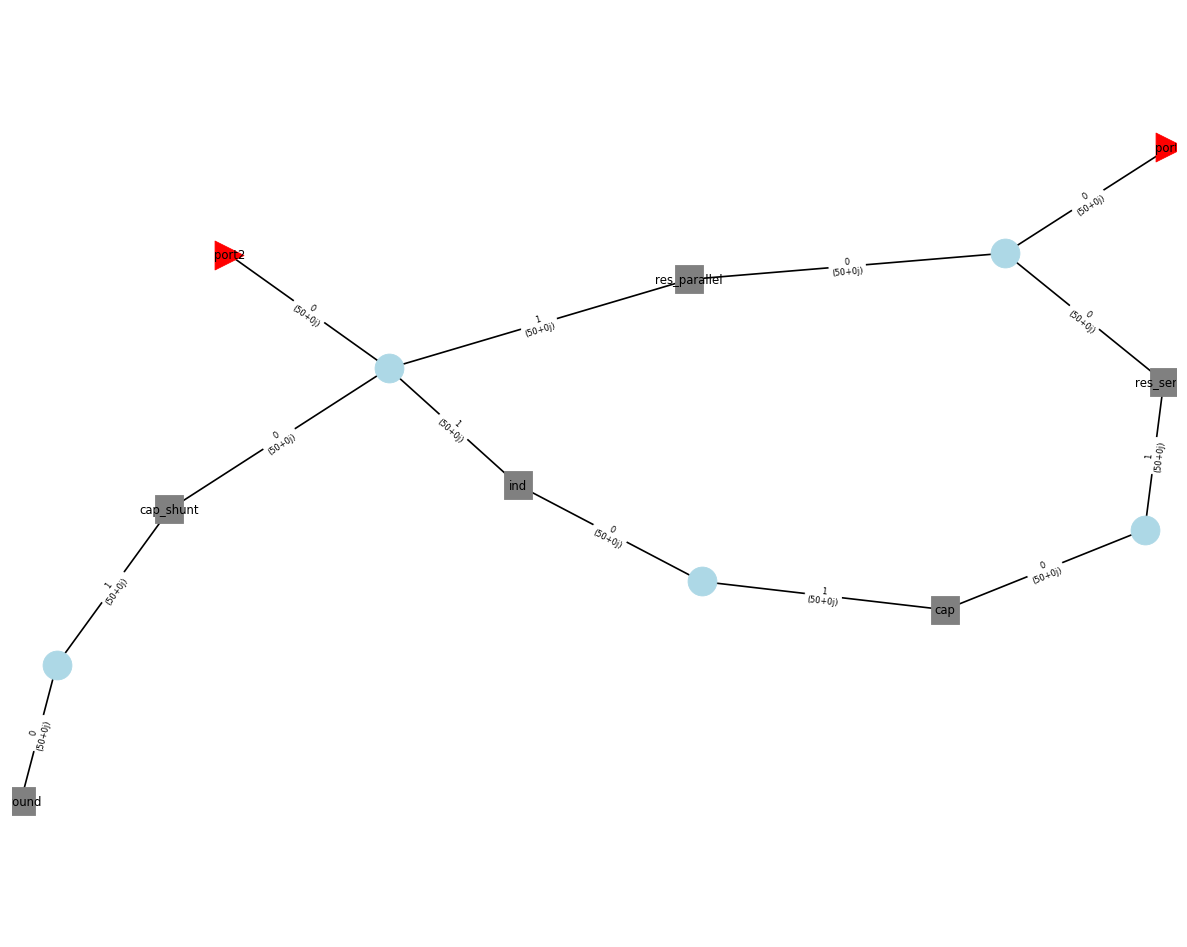

In [42]:
circuit.plot_graph(network_labels=True, edge_labels=True, port_labels=True)

# Pass band filter

Below we construct a pass-band filter, from an example given in [Microwaves101](https://www.microwaves101.com/encyclopedias/lumped-element-filter-calculator):

<img src="designer_bandpass_filter_450_550MHz.png" style="height:300px">


In [30]:
# Reference result calculated from Designer
passband_designer = rf.Network('designer_bandpass_filter_450_550MHz.s2p')

In [31]:
# scikit-rf: 
freq = passband_designer.frequency
passband_manual = line.shunt_capacitor(25.406e-12) ** line.shunt_inductor(4.154e-9) ** \
                  line.capacitor(2.419e-12) ** line.inductor(43.636e-9) ** \
                  line.shunt_capacitor(25.406e-12) ** line.shunt_inductor(4.154e-9)

In [36]:
# scikit-rf: the filter with the Circuit builder
freq = passband_designer.frequency
line = rf.media.DefinedGammaZ0(frequency=freq)
C1 = line.capacitor(25.406e-12, name='C1')
C2 = line.capacitor(2.419e-12, name='C2')
C3 = line.capacitor(25.406e-12, name='C3')
L1 = line.inductor(4.154e-9, name='L1')
L2 = line.inductor(43.636e-9, name='L2')
L3 = line.inductor(4.154e-9, name='L3')
port1 = rf.Circuit.Port(frequency=freq, name='port1', z0=50)
port2 = rf.Circuit.Port(frequency=freq, name='port2', z0=50)
ground1 =  rf.Circuit.Ground(frequency=freq, name='ground1', z0=50)
ground2 =  rf.Circuit.Ground(frequency=freq, name='ground2', z0=50)
ground3 =  rf.Circuit.Ground(frequency=freq, name='ground3', z0=50)
ground4 =  rf.Circuit.Ground(frequency=freq, name='ground4', z0=50)

connections = [
    [(port1, 0), (C1, 0), (L1, 0), (C2, 0)],
    [(C2, 1), (L2, 0)],
    [(L2, 1), (C3, 0), (L3, 0), (port2, 0)],
    # grounding must be done on ground ntw having different names
    [(C1, 1), (ground1, 0)],
    [(C3, 1), (ground2, 0)],
    [(L1, 1), (ground3, 0)],
    [(L3, 1), (ground4, 0)],
]

circuit = rf.Circuit(connections)
passband_circuit = circuit.network
passband_circuit.name = 'Pass-band circuit'

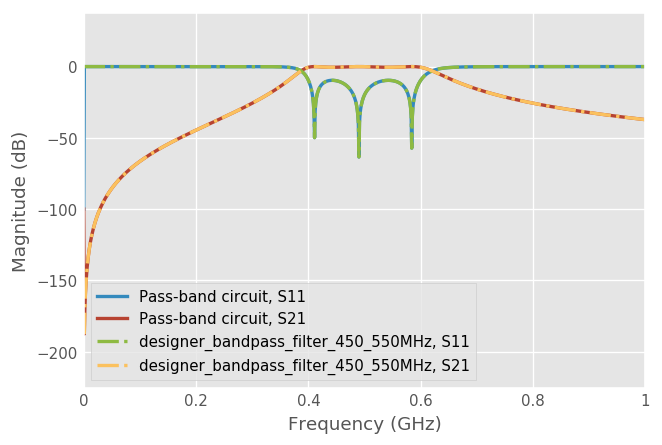

In [37]:
passband_circuit.plot_s_db(m=0, n=0, lw=2)
passband_circuit.plot_s_db(m=1, n=0, lw=2)
passband_designer.plot_s_db(m=0, n=0, lw=2, ls='-.')
passband_designer.plot_s_db(m=1, n=0, lw=2, ls='-.')

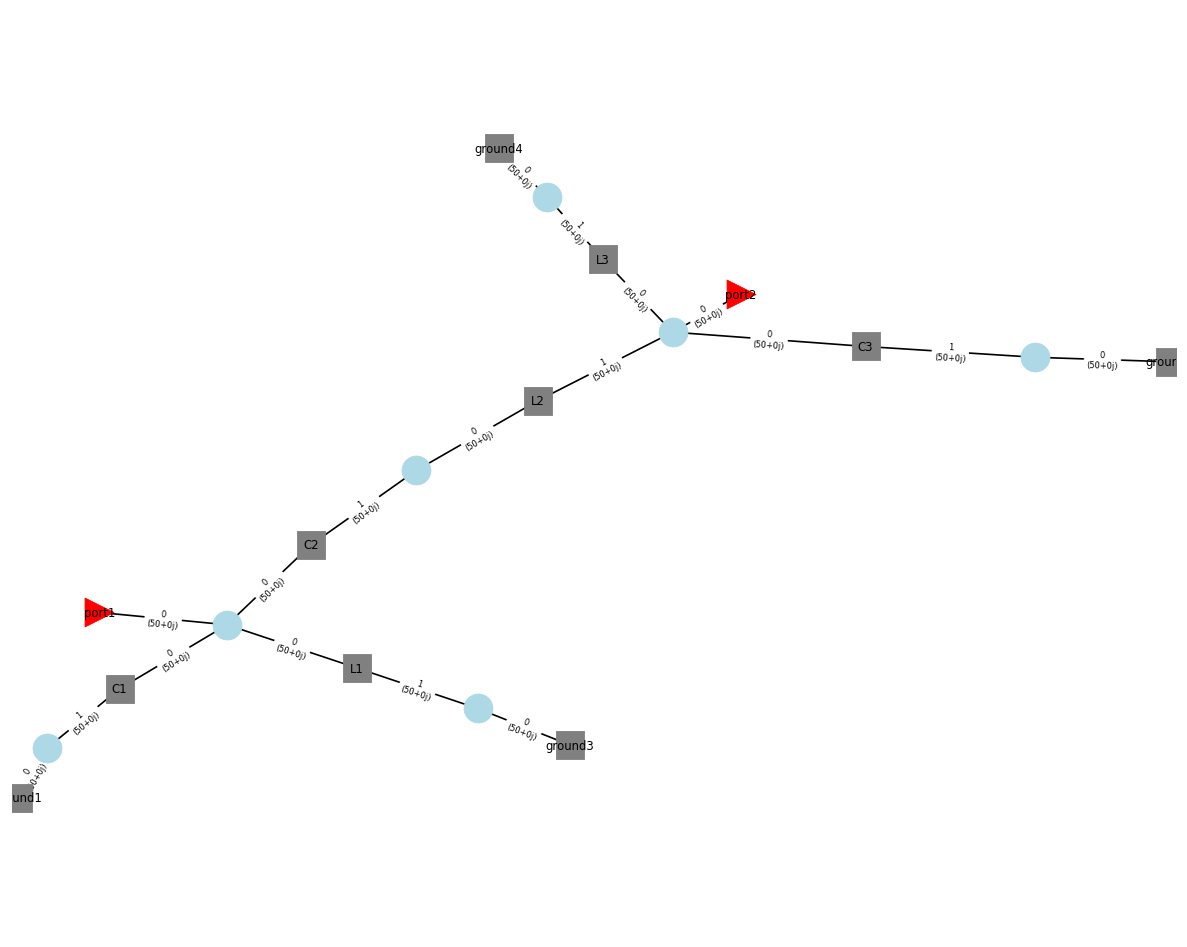

In [35]:
circuit.plot_graph(network_labels=True, port_labels=True, edge_labels=True)